In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def plotPoke(x):
    f, a = plt.subplots(2, 8, figsize=(8, 2))
    for i in range(8):
        a[0][i].imshow(x[i], cmap=plt.get_cmap('gray'))
        a[0,i].axis('off')
        a[1][i].imshow(x[i+8], cmap=plt.get_cmap('gray'))
        a[1,i].axis('off')
    f.show()
    plt.draw()

Input data shape: (792, 40, 40, 3)


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


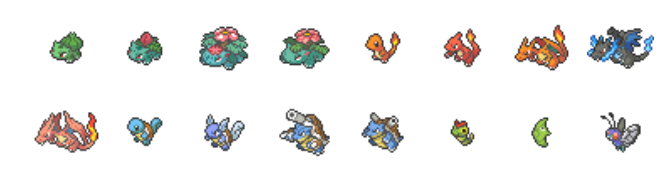

In [3]:
# Create an empty array to store pokemon pics
orig_img = np.empty((0, 40, 40, 3), dtype='float32')
# Load all images and append into orig_img
path = os.path.abspath("./AE_RGB.ipynb")
path = re.sub('[a-zA-Z\s._]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,0:3]
    orig_img = np.append(orig_img, [img], axis=0)

# Use plt to show original images 
print 'Input data shape: {}'.format(orig_img.shape)
plotPoke(orig_img)

In [4]:
# Parameters
learning_rate = 0.001
training_epochs = 10000
batch_size = 24
display_step = 500
examples_to_show = 8

# Network Parameters
n_input = [40, 40, 3] # Pokemon data input (img shape: 40*40*3)
n_channel1 = 16
n_channel2 = 32

# tf Graph input
X = tf.placeholder(tf.float32, [None]+n_input)

In [5]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 3 inputs, 32 outputs
    'wec1': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel1], stddev=0.01)),
    # 5x5 conv, 32 inputs, 64 outputs
    'wec2': tf.Variable(tf.truncated_normal([5, 5, n_channel1, n_channel2], stddev=0.01)),
    # 5x5 conv, 3 inputs, 32 outputs
    'wdc1': tf.Variable(tf.truncated_normal([5, 5, n_channel1, n_channel2], stddev=0.01)),
    # 5x5 conv, 32 inputs, 64 outputs
    'wdc2': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel1], stddev=0.01))
}

biases = {
    'bec1': tf.Variable(tf.truncated_normal([n_channel1], stddev=0.01)),
    'bec2': tf.Variable(tf.truncated_normal([n_channel2], stddev=0.01)),
    'bdc1': tf.Variable(tf.truncated_normal([n_channel1], stddev=0.01)),
    'bdc2': tf.Variable(tf.truncated_normal([3], stddev=0.01))
}

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=2):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def deconv2d(x, W, b, out_shape, strides=2):
    x = tf.nn.conv2d_transpose(x, W, out_shape, strides=[1, strides, strides, 1], 
                               padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)
    
# Create model
def conv_net(x, weights, biases):

    # Convolution Layer
    conv1 = conv2d(x, weights['wec1'], biases['bec1'])
    # Convolution Layer
    conv2 = conv2d(conv1, weights['wec2'], biases['bec2'])

    # Transpose Convolution Layer
    out_dim1 = tf.pack([tf.shape(x)[0], 20, 20, n_channel1])
    deconv1 = deconv2d(conv2, weights['wdc1'], biases['bdc1'], out_dim1)

    # Transpose Convolution Layer
    out_dim2 = tf.pack([tf.shape(x)[0], 40, 40 ,3])
    deconv2 = deconv2d(deconv1, weights['wdc2'], biases['bdc2'], out_dim2)

    return deconv2

In [7]:
# Construct model
pred = conv_net(X, weights, biases)
y = X

# Define loss and optimizer
cost = tf.reduce_mean(tf.pow(pred - y, 2))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [8]:
sess = tf.InteractiveSession()
sess.run(init)
total_batch = int(orig_img.shape[0]/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    start = 0; end = batch_size-1
    for i in range(total_batch):
        index = np.arange(start, end)
        np.random.shuffle(index)
        batch_xs = orig_img[index]
        start = end+1; end = start+batch_size-1
        # Run optimization op (backprop) and loss op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if ((epoch == 0) or (epoch+1) % display_step == 0) or ((epoch+1) == training_epochs):
        print 'Epoch: {0:05d}   loss: {1:f}'.format(epoch+1, c)

print("Optimization Finished!")

Epoch: 00001   loss: 0.202613
Epoch: 00500   loss: 0.003753
Epoch: 01000   loss: 0.003562
Epoch: 01500   loss: 0.003355
Epoch: 02000   loss: 0.003858
Epoch: 02500   loss: 0.003358
Epoch: 03000   loss: 0.003304
Epoch: 03500   loss: 0.003409
Epoch: 04000   loss: 0.003348
Epoch: 04500   loss: 0.003300
Epoch: 05000   loss: 0.003309
Epoch: 05500   loss: 0.003286
Epoch: 06000   loss: 0.003451
Epoch: 06500   loss: 0.003239
Epoch: 07000   loss: 0.003283
Epoch: 07500   loss: 0.003217
Epoch: 08000   loss: 0.003216
Epoch: 08500   loss: 0.003249
Epoch: 09000   loss: 0.003235
Epoch: 09500   loss: 0.003240
Epoch: 10000   loss: 0.003296
Optimization Finished!


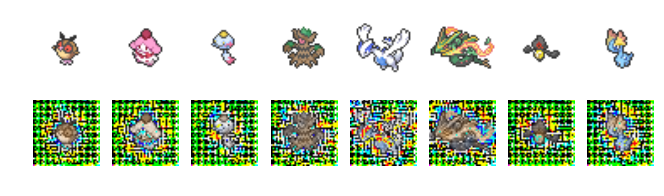

In [9]:
# Random select some pokemon to visualization
index = np.random.randint(orig_img.shape[0], size=examples_to_show)
convAE = sess.run(
    pred, feed_dict={X: orig_img[index]})

# Compare original images with their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(orig_img[index[i]])
    a[0,i].axis('off')
    a[1][i].imshow(convAE[i])
    a[1,i].axis('off')
f.show()
plt.draw()

In [10]:
# Save weights and biases
weights_saver = tf.train.Saver(var_list=weights)
biases_saver = tf.train.Saver(var_list=biases)
weights_saver.save(sess, 'Conv_AE_weights')
biases_saver.save(sess, 'Conv_AE_biases')

'Conv_AE_biases'